The goal of this analysis is to find the proportion of Bob Ross paintings that contain a conifer element. Bob Ross is famous for his happy little trees. Using conifers for this analysis is a purely arbitrary choice, but provides insight into the painting preferences of Ross and the environments he chose to paint nonetheless. Bob Ross was a greatly influential on the amature painting space and the distribution of the elements he chose to use in his paintings will undoubtably have an impact on the styles that artists use in creating those elements themselves.

In [2]:
# I figure if the assigment is essentially to do the unit 2 class work with new
# data I should import all relevant libraries.
!pip install preliz
import preliz as pz
import numpy as np
import arviz as az
import pymc as pm
#now I'm going to import my data which I found on 538's data repository.
import pandas as pd
element_Table_Url = 'https://raw.githubusercontent.com/ColeHenson/Data-Science24-25/main/elements-by-episode.csv';
Element_Data = pd.read_csv(element_Table_Url);
Element_Data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


,EPISODE,TITLE,APPLE_FRAME,AURORA_BOREALIS,BARN,BEACH,BOAT,BRIDGE,BUILDING,BUSHES,...,TOMB_FRAME,TREE,TREES,TRIPLE_FRAME,WATERFALL,WAVES,WINDMILL,WINDOW_FRAME,WINTER,WOOD_FRAMED
0,S01E01,"""A WALK IN THE WOODS""",0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
1,S01E02,"""MT. MCKINLEY""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
2,S01E03,"""EBONY SUNSET""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
3,S01E04,"""WINTER MIST""",0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
4,S01E05,"""QUIET STREAM""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,S31E09,"""EVERGREEN VALLEY""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
399,S31E10,"""BALMY BEACH""",0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
400,S31E11,"""LAKE AT THE RIDGE""",0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
401,S31E12,"""IN THE MIDST OF WINTER""",0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0


The data came from the 538 data repository and represents the elements of Ross' paintings in his tv show, “The Joy of Painting”. Now that all the data and libraries are downloaded from the, it's time to start with a prior. Bob Ross is very well known for his happy little trees and coniferous trees are very common so I think it is safe to assume that 95% of his paintings have trees in them and of those 95% roughly 60% have coniferous tress in them. That gives an estimate of 57% of his paintings containing trees. (P(A and B) = P(A) * P(B)) There are 403 episodes in total so that gives 230 episodes with coniferous trees and 173 episodes that don't contain them.

(0.5707196029776674, 0.5708367075253026, 0.571072319201995, <Axes: >)

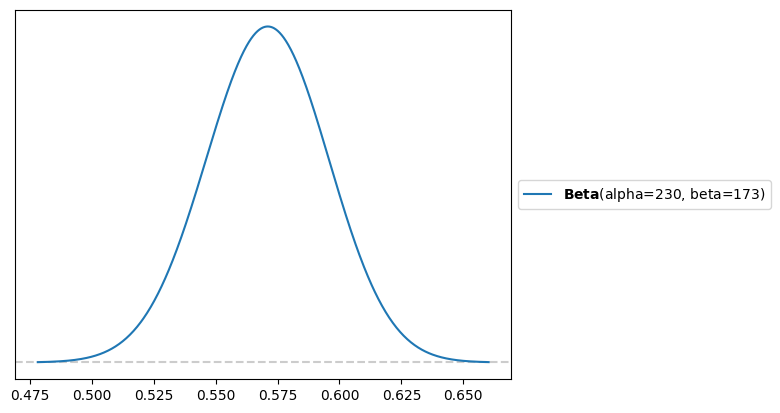

In [3]:
# first I'm going to use my priors to make an estimation as to the true results
# distribution of coniferous trees in Bob Ross videos
Tree_prior = pz.Beta(alpha=230,beta=173)
Tree_prior_mode = (Tree_prior.alpha - 1)/(Tree_prior.alpha + Tree_prior.beta - 2)
Tree_prior.mean(), Tree_prior.median(), Tree_prior_mode, pz.Beta(alpha=230,beta=173).plot_pdf()


In [4]:
# now its time to encorperate the new data yay!
num_conifers = Element_Data.query('CONIFER == True')
# to find the real number of conifer elements, I look at the number of rows
num_conifers.shape[0]

212

Ok so the true number of conferous elements is 212/403 episodes. But I care about what the true probability that Bob Ross would have a coniferous element in a given episode if he continued to make episodes past 403. Now I need to update my prior.

0.5483870967741935

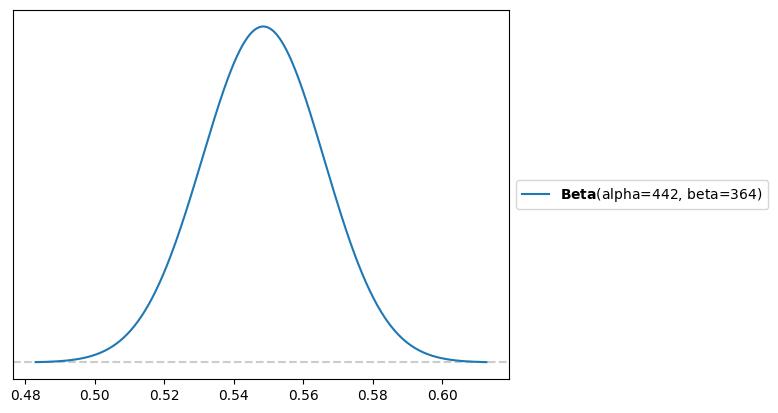

In [5]:
# I'm making a beta distribution with the combined results of my prior and the data
alpha_old = 230
beta_old = 173
# k is number with conifers, n is total number of episodes
k = 212
n = 403
analytic_conifers = pz.Beta(alpha = alpha_old + k,beta = beta_old + n - k)
analytic_conifers.plot_pdf()
analytic_conifers.mean()


Now it's time to make a pymc model!

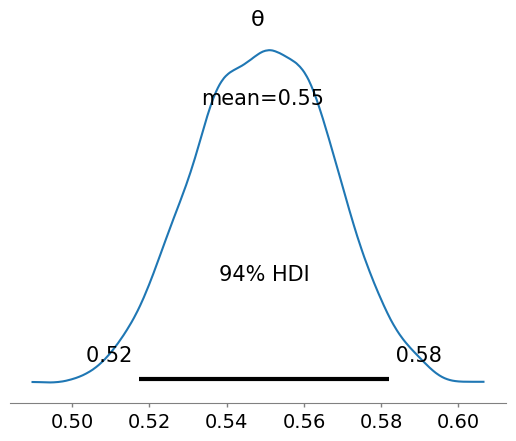

In [8]:
# I already imported pymc
Coniferous_data = np.repeat([1,0], repeats = [212,(403-212)])
# basically just copying the process from the unit2 ak
with pm.Model() as wmby_FT_model:

  θ = pm.Beta('θ' , alpha = 230. , beta = 173.)
  y = pm.Bernoulli('y', p = θ, observed = Coniferous_data)
  idata_Coniferous = pm.sample(1000)
  az.plot_posterior(idata_Coniferous)


The posterior is my prior adjusted to the values of the data from the “The Joy of Painting” tv show. Therefore it is expected rha the mean would fall between that prior and the real data. And it does. Really the data is more likely to be closer to the true proportion of paintings with coniferous elements than my guess. The model provides a relatively thin distribution which I would expect because I have a large quantity of data.